In [1]:
import os
import sys

import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor

sys.path.append(r"../")
from data_loader import category_data_loader

In [2]:
IS_CUSTOM = True
USE_VALID = True
USE_PCA = False
show=True
valid_len = 3
n_components = 5

DROPS = [
    'Timestamp','year','day','minute','second','KnowledgeTag',
]
PCA = [
    'hour_answerCode_sum',
    'userID_dayofweek_answerCode_count',
    'user_correct_answer',
    'user_total_answer',
    'hour_answerCode_var',
    'hour_answerCode_mean',
    'userID_first3_answerCode_count',
    'userID_month_answerCode_count',
    'KnowledgeTag_first3_answerCode_sum',
    'KnowledgeTag',
    'userID_answerCode_count',
    'userID_answerCode_sum',
    'testId_answerCode_sum',
    'KnowledgeTag_answerCode_count',
    'KnowledgeTag_answerCode_sum',
    'month',
    'hour',
    'dayofweek',
    'dayofweek_answerCode_mean',
    'dayofweek_answerCode_count',
    'dayofweek_answerCode_sum',
    'dayofweek_answerCode_var',
    'mid3',
    'KnowledgeTag_first3_answerCode_mean',
    'KnowledgeTag_first3_answerCode_count',
    'month_answerCode_var',
    'month_answerCode_count',
    'hour_answerCode_count', 
    'KnowledgeTag_first3_answerCode_var',
]

# CTB preprocessing

In [3]:
x_train, x_valid, y_train, y_valid, test, cat_features = category_data_loader(IS_CUSTOM=IS_CUSTOM, USE_VALID=USE_VALID, DROPS=DROPS, valid_len=valid_len,PCA=PCA, n_components=5, USE_PCA=USE_PCA)

Label Encoding...: 100%|██████████| 69/69 [00:08<00:00,  7.77it/s]


Start binning


Binning...: 100%|██████████| 17/17 [00:23<00:00,  1.35s/it]


# CatBoostRegressor

In [9]:
model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", leaf_estimation_iterations=10, od_type="Iter", logging_level="Silent")
if USE_VALID:
    model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", use_best_model=True, leaf_estimation_iterations=10, od_type="Iter", early_stopping_rounds=100, logging_level="Silent")

predict = None
param_grid = {
        'iterations': [4000],
        'depth': [10],
        'learning_rate': [0.001],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    pre_dispatch=8,
)

In [10]:
if USE_VALID:
    gcv.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],plot=show, verbose=show)
else:
    gcv.fit(x_train, y_train,plot=show, verbose=show)
print("final params", gcv.best_params_)
print("best score", gcv.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

final params {'depth': 10, 'iterations': 4000, 'learning_rate': 0.001}
best score 0.8584868391113495


In [11]:
# SAVE OUTPUT
model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(test.drop("answerCode", axis=1))

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"CTB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/CTB_R_grid_kfold_custom_submission_2022-12-01_16:21:23.csv


In [46]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [ ]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


accuracy_score: 0.7217741935483871
roc  auc_score: 0.7798804708016649


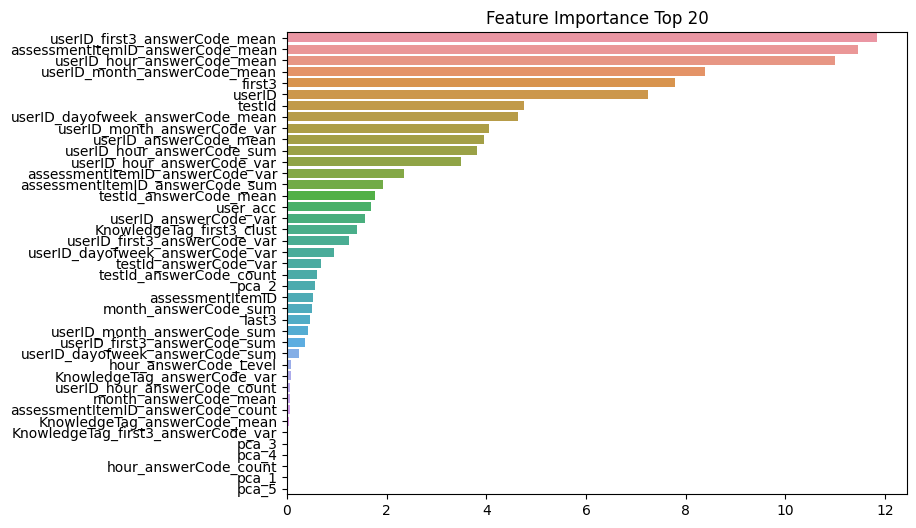

In [ ]:
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
perm_importance = permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=1066)

Text(0.5, 1.0, 'Permutation Importance')

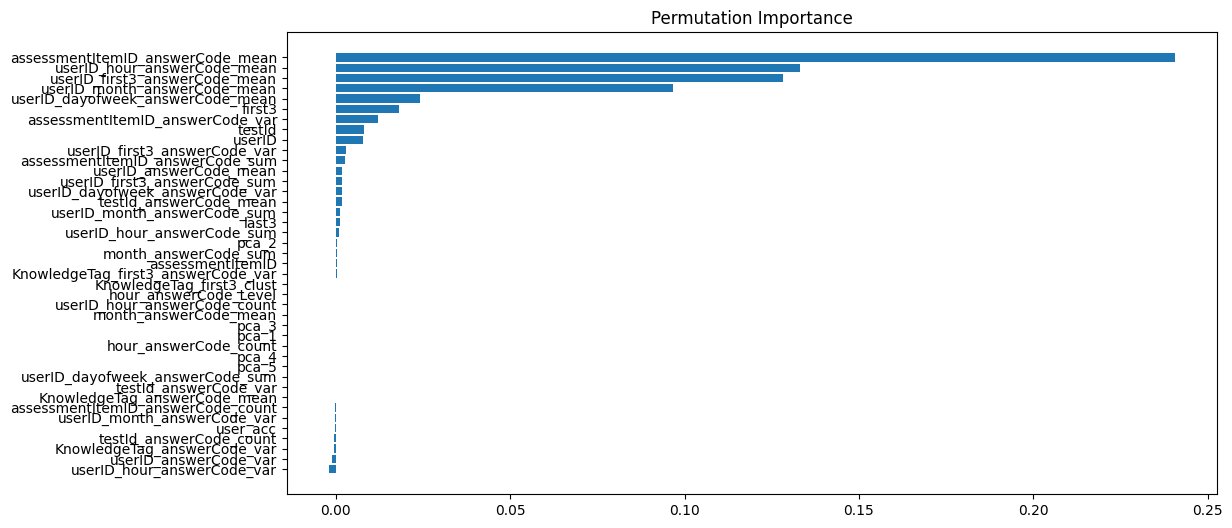

In [ ]:
sorted_mead_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_mead_idx)), perm_importance.importances_mean[sorted_mead_idx], align='center')
plt.yticks(range(len(sorted_mead_idx)), np.array(x_valid.columns)[sorted_mead_idx])
plt.title('Permutation Importance')

Text(0.5, 1.0, 'Permutation Importance')

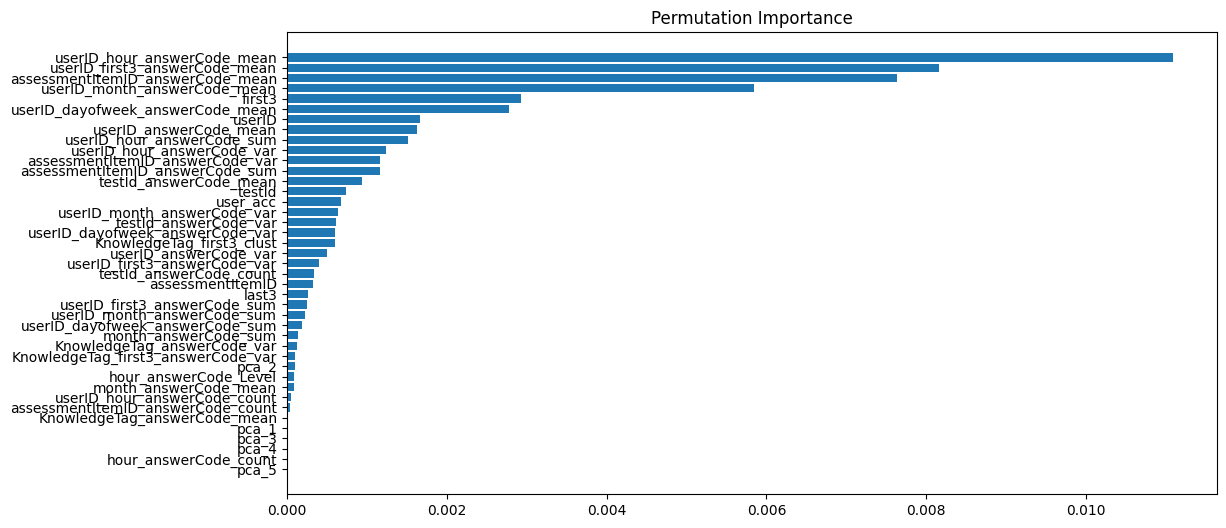

In [ ]:
sorted_std_idx = perm_importance.importances_std.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_std_idx)), perm_importance.importances_std[sorted_std_idx], align='center')
plt.yticks(range(len(sorted_std_idx)), np.array(x_valid.columns)[sorted_std_idx])
plt.title('Permutation Importance')

In [ ]:
mean_bad = [x_valid.columns[i] for i in perm_importance.importances_mean.argsort()[:35]]
std_bad = [x_valid.columns[i] for i in perm_importance.importances_std.argsort()[:35]]

In [ ]:
from collections import Counter
a,b,c = Counter(ft_series.sort_values(ascending=False).index[35:]), Counter(mean_bad), Counter(std_bad)
[k for k,v in (a+b+c).items() if v==3]

['KnowledgeTag_first3_answerCode_var',
 'pca_3',
 'pca_4',
 'hour_answerCode_count',
 'pca_1',
 'pca_5']

['KnowledgeTag',
 'KnowledgeTag_answerCode_count',
 'KnowledgeTag_answerCode_sum',
 'KnowledgeTag_first3_answerCode_count',
 'KnowledgeTag_first3_answerCode_mean',
 'KnowledgeTag_first3_answerCode_sum',
 'dayofweek',
 'dayofweek_answerCode_count',
 'dayofweek_answerCode_mean',
 'dayofweek_answerCode_sum',
 'dayofweek_answerCode_var',
 'hour',
 'hour_answerCode_mean',
 'hour_answerCode_sum',
 'hour_answerCode_var',
 'mid3',
 'month',
 'month_answerCode_count',
 'month_answerCode_var',
 'testId_answerCode_sum',
 'userID_answerCode_count',
 'userID_answerCode_sum',
 'userID_dayofweek_answerCode_count',
 'userID_first3_answerCode_count',
 'userID_month_answerCode_count',
 'user_correct_answer',
 'user_total_answer']